In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def load_mnist(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

In [4]:
def encode(y):
    if type(y) == int or y.size == 1:
        if y > 9 :
            raise Exception("Nombre à encoder trop élevé", y)
        y = np.array(y, ndmin = 1)
    a = np.ones((y.size, 10)) * -1
    for i in range(len(a)):
        if y[i] > 9 :
            raise Exception("Nombre à encoder trop élevé", y[i])
        a[i,y[i]] = 1
    return a

In [5]:
def accuracy(yPred, y):
    return np.mean(yPred == y)

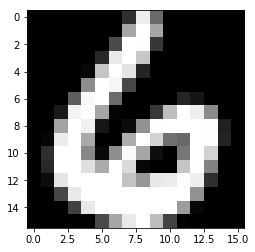

6


In [6]:
'''256 > linéaire > 500 > sig > 500 > linéaire > 10 > sig > 10'''
train = load_mnist("USPS_train.txt")
test = load_mnist("USPS_test.txt")
plt.imshow(train[0][0].reshape(16,16), cmap='gray')
plt.show()
print(train[1][0])

In [7]:
class Loss(object):
    def forward(self, yPred, y):
        pass

    def backward(self, yPred, y):
        pass

class Module(object):
    def forward(self, x):
        pass

    def backward(self, x, delta):
        pass

    def update(self):
        pass

In [8]:
class SquareLoss(Loss):
    def forward(self, yPred, y):
        return (yPred - y) * (yPred - y)

    def backward(self, yPred, y):
        return (2 * yPred - 2 * y) / yPred.size

In [9]:
class Linear(Module):
    def __init__(self, n, e = 0.0001, rand = True):
        '''n taille vecteur de sortie'''
        self.ini = False
        self.n = n
        self.eps = e
        self.rand = rand
    
    def init(self, n):
        if self.rand :
            self.param = np.random.rand(n, self.n)
        else :
            self.param = np.ones((n, self.n))
        self.grad = np.zeros((n, self.n))
        self.gradHisto = self.grad.reshape((1, n, self.n))
        self.ini = True

    def forward(self, x):
        if len(x.shape) == 1 :
            x = x.reshape((1,x.size))
        if self.ini == False :
            self.init(x.shape[1])
        return np.dot(x, self.param)
    
    def backward(self, x, theta):
        if len(x.shape) == 1 :
            x = x.reshape((1, x.size))
        if len(theta.shape) == 1:
            theta = theta.reshape((1, theta.size))
        g = theta * x.T
        self.grad += g
        self.gradHisto = np.concatenate((self.gradHisto, g.reshape((1, -1, self.n))))
        return np.dot(theta, self.param.T)
        
    def update(self):
        self.param = self.param - self.eps * self.grad

In [10]:
class GroupMod(Module):
    '''Module servant à regrouper d'autre modules '''
    def __init__(self, m, e = 0.0001):
        self.mod = m
        self.eps = e
    
    def forward(self, x):
        self.x = [x]
        for i in range(len(self.mod)):
            self.x.append(self.mod[i].forward(self.x[-1]))
        return self.x[-1]
    
    def backward(self, x, theta):
        '''doit impérativement être précèdé d'un forward '''
        for i in range(len(self.mod)):
            theta = self.mod[-i-1].backward(self.x[-i-2], theta)
        return theta

    def update(self):
        for i in range(len(self.mod)):
            self.mod[i].eps = self.eps
            self.mod[i].update()

In [11]:
class Htan(Module):
    def forward(self, x):
        return (1 - np.exp(-2*x))/(1+np.exp(-2*x))
    
    def backward(self, x, theta):
        return theta * (4*np.exp(-2*x))/((1+np.exp(-2*x)) * (1+np.exp(-2*x)))

In [12]:
x = np.arange(6)
h = Htan()
print(h.forward(x), h.backward(x, 5))

[ 0.          0.76159416  0.96402758  0.99505475  0.9993293   0.9999092 ] [  5.00000000e+00   2.09987171e+00   3.53254124e-01   4.93301858e-02
   6.70475342e-03   9.07916155e-04]


In [13]:
l = Linear(4)
l2 = Linear(10)
s = SquareLoss()
a = l.forward(train[0][0:3])
b = l2.forward(a)
c = h.forward(b)
y = s.forward(c, encode(train[1][0]))
print(a,b, c, y)

[[  93.77883704   87.89536462   84.42112269   84.53888277]
 [ 128.34470239  120.00116675  115.02327623  105.43984764]
 [  54.01750644   54.05807327   62.88981678   49.32925777]] [[ 139.44864164  215.85025765  172.16631283  146.35132287  151.12303409
   240.99924768  162.28214845  100.1896464   215.78854091  232.75206364]
 [ 184.14455945  284.97218786  229.34528233  198.94497389  200.0652539
   319.63607101  221.45213258  133.29198595  286.31547697  309.86739742]
 [  94.35234297  138.82241862  105.28844944   91.01176341   91.82292119
   150.02809488  105.47331239   59.59258622  139.42758721  142.6261725 ]] [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]] [[ 4.  4.  4.  4.  4.  4.  0.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  0.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  0.  4.  4.  4.]]


In [14]:
def gradStoAff(m, l, tx, ty, tex, tey, n = 100, f = 3):
    ''' x in size N*arg'''
    errt = []
    errte = []
    for i in range(n):
        errt.append(l.forward(m.forward(tx), ty))
        errte.append(l.forward(m.forward(tex), tey))
        j = np.random.randint(0,len(tx))
        yPred = m.forward(tx[j])
        theta = l.backward(yPred[-1], ty[j])
        m.backward(tx[j], theta)
        m.update()
        if i%(n//f) == 0 :
            m.eps = m.eps/2
    return errt, errte

In [15]:
l = Linear(10)
errt, errte = gradStoAff(l, s, train[0], encode(train[1]), test[0], encode(test[1]))

ValueError: x and y can be no greater than 2-D, but have shapes (100,) and (100, 7291, 10)

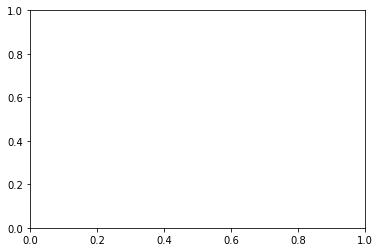

In [16]:
plt.plot(errt, 'b')
plt.plot(errte, 'r')
plt.show()
print(np.min(errt), np.min(errte)) 

In [ ]:
l = []
l.append(Linear(500))
l.append(Htan())
l.append(Linear(10))
l.append(Htan())
m = GroupMod(l)
errt, errte = gradStoAff(m, s, train[0], encode(train[1]), test[0], encode(test[1]))

In [ ]:
plt.plot(errt, 'b')
plt.plot(errte, 'r')
plt.show()
print(np.min(errt), np.min(errte)) 

In [ ]:
m.mod[2].gradHisto[0]

Le gradient du 2è module linéaire est très faible car il y a beaucoups de bonnes dimensions de sortie (9 dimensions sur 10 sont bonnes), la chaine de module fonctionne mais il faut revoir la fonction de loss.

In [ ]:
m.forward(train[0][0])